In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [118]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import re
import json
import collections


from util import get_data
from util import mapping
from util import clean_data
from util import config
from util import plot_clusters

import sklearn.cluster
import sklearn.neighbors
import scipy

import hdbscan
import umap

In [ ]:
# df = pd.read_csv(config.PROCESSED_DATA_PATH + 'trips.csv')
# df = clean_data.filter_cleaned_trips(df)
# print(df.shape)
grid_points, grid_dict = clean_data.load_gridpts('road_backbone_coarse', 'grid_rte_ids_coarse')

In [ ]:
# a = rts_at_grid#pd.read_csv(config.MODEL_PATH + 'rts_at_fine_grid.csv')
# print(a.shape)
# a.head()
grid_points.rename(columns={'grid_i': 'grid_id'}, inplace=True)
grid_points.head()
# df.rename(columns={'id': 'rte_id'}, inplace=True)
# df.reset_index(inplace=True)
# df.tail()
len(grid_dict)

In [ ]:
rts.head()

In [ ]:
# Feather everything!
# df.to_feather(config.PROCESSED_DATA_PATH + 'trips.feather')
# grid_points.to_feather(config.MODEL_PATH + 'grid_points_fine.feather')
# rts_at_grid.to_feather(config.MODEL_PATH + 'rtes_at_grid_fine.feather')
# rts.to_feather(config.PROCESSED_DATA_PATH + 'gridpts_at_rte_fine.feather')
grid_points.to_feather(config.MODEL_PATH + 'grid_points_coarse.feather')
rts_at_grid.to_feather(config.MODEL_PATH + 'rtes_at_grid_coarse.feather')
rts.to_feather(config.PROCESSED_DATA_PATH + 'gridpts_at_rte_coarse.feather')

In [ ]:
# rts_at_grid.rte_ids.apply(len).describe()
# rts_at_grid.rte_ids.apply(len).describe()
# rts_at_grid.grid_id.max()
rts.head()

In [ ]:
rte_dict = collections.defaultdict(list)
for grid_id, rte_set in grid_dict.items():
    for rte_id in rte_set:
        rte_dict[rte_id] += [grid_id]

In [ ]:
rts_at_grid = []
for k, v in grid_dict.items():
    rts_at_grid += [{'grid_id': k, 'rte_ids': list(v)}]
rts_at_grid = pd.DataFrame(rts_at_grid)#.set_index('grid_id')
# rts_at_grid.to_csv(config.MODEL_PATH + 'rts_at_fine_grid.csv')

In [ ]:
rts = []
for k, v in rte_dict.items():
    rts += [{'rte_id': k, 'grid_ids': list(v)}]
rts = pd.DataFrame(rts)#.set_index('rte_id')
# rts.to_csv(config.MODEL_PATH + 'rts_grid_pts.csv')

In [ ]:
a = pd.read_feather('../EasyRider-Deployment/data/processed/rts_grid_pts.feather')
a.shape

In [ ]:
# grid_points.grid_id.max()

In [ ]:
# rts_at_grid.rte_ids = rts_at_grid.rte_ids.apply(lambda x: list(x))
# rts_at_grid.rte_ids[0]
rts_at_grid.shape

In [ ]:
rts_at_grid.to_csv(config.MODEL_PATH + 'rts_at_fine_grid.csv')

In [ ]:
# gp = grid_points.set_index('grid_i')
rts_gridpts = pd.read_csv(config.MODEL_PATH + 'rts_grid_pts.csv', index_col=0)
rts_at_grid = pd.read_csv(config.MODEL_PATH + 'rts_at_fine_grid.csv', index_col=0)

rts_gridpts.grid_pts = rts_gridpts.grid_pts.apply(lambda x: [int(a) for a in x.strip('[]').split(',')])
rts_at_grid.rte_ids = rts_at_grid.rte_ids.apply(lambda x: set([int(a) for a in x.strip('{}').split(',')]))

In [ ]:

type(rts_at_grid.loc[8229794].rte_ids)

In [ ]:
locs = gp.loc[rts.loc[11439445].grid_pts][['lat', 'lon']]
plt.plot(locs.lon, locs.lat, 'k.')

In [ ]:
colours = sns.color_palette('husl', 5)
[x * 255 for x in colours[0]]

In [ ]:
ride_points = locs
map_lims = np.array([[90, -90, 180, -180]])
map_lims = np.vstack((map_lims, 
                    np.array([[ride_points.lat.min(),
                               ride_points.lat.max(),
                               ride_points.lon.min(),
                               ride_points.lon.max()]])))
print(tuple(map_lims[:, 1:4:2].max(axis=0)))
tuple(map_lims[:, 0:3:2].min(axis=0))

## Deduping proper

In [3]:
# Make dataframe with rows of rte_id, columns of grid_ids
# Where 1 means that rte goes through that grid point, 0 not

# Load data
pts_per_degree = 25
grid_pts = pd.read_feather(config.MODEL_PATH + 'grid_points_{}.feather'.format(pts_per_degree))
rtes_at_grid = pd.read_feather(config.MODEL_PATH + 'rtes_at_grid_{}.feather'.format(pts_per_degree))
gridpts_at_rte = pd.read_feather(config.PROCESSED_DATA_PATH + 'gridpts_at_rte_{}.feather'.format(pts_per_degree))

rtes_at_grid.set_index('grid_id', inplace=True)
gridpts_at_rte.set_index('rte_id', inplace=True)

In [ ]:
import pandas as pd
from util import config

In [ ]:
rte_grid_ohe.head(10)

In [ ]:
rte_grid_ohe.dtypes

In [4]:
rte_grid_ohe = gridpts_at_rte.copy()
rte_grid_ohe.drop('grid_ids', axis=1, inplace=True)
# rte_grid_ohe.loc[rtes_at_grid.loc[46333].rte_ids].shape

for i, grid_id in enumerate(rtes_at_grid.index.tolist()):
    if not i % 200: print(i)
    rte_grid_ohe[grid_id] = False
    rte_grid_ohe.loc[rtes_at_grid.loc[grid_id].rte_ids, grid_id] = True

a = dict()
for gi in rte_grid_ohe.columns:
    a[gi] = str(gi)
rte_grid_ohe.rename(columns=a).reset_index().to_feather(config.PROCESSED_DATA_PATH + 'gridpts_at_rte_{}_ohe.feather'.format(pts_per_degree))

0
200
400
600
800
1000
1200
1400


In [ ]:
sdf = rte_grid_ohe.astype(pd.SparseDtype("bool", False))
rte_grid_ohe.head()

In [ ]:
print(rte_grid_ohe.shape[0] * rte_grid_ohe.shape[1])
rte_grid_ohe.values.sum().sum()

In [5]:
sda = scipy.sparse.csr_matrix(rte_grid_ohe.values)
sda.nnz
# sdf.sparse.density
# sda = pd.arrays.SparseArray(rte_grid_ohe, fill_value=False)
# rte_grid_ohe.values

225448

In [6]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1) 
                              #min_cluster_size=100,
                              #min_samples=1,
                              #cluster_selection_epsilon=0.)
clusterer.fit(sda)

HDBSCAN(min_cluster_size=2, min_samples=1)

In [119]:
reducer = umap.UMAP().fit_transform(sda)
xu = reducer[:, 0]
yu = reducer[:, 1]

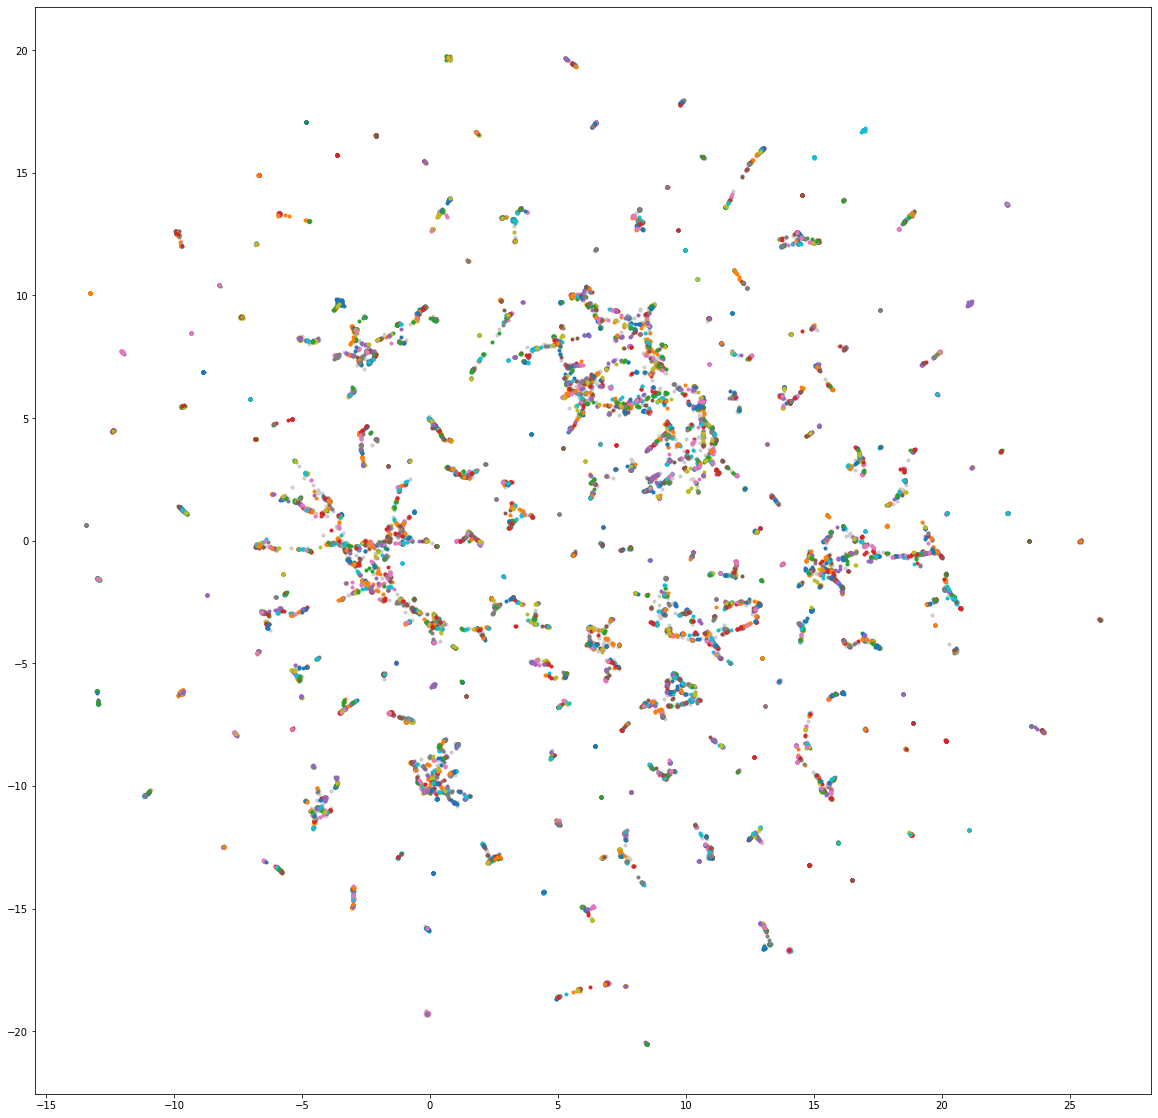

In [123]:
labels = clusterer.labels_
plt.figure(figsize=(20, 20))
for c in lab_counts.label:
    if c == -1: 
        plt.plot(xu[labels == c], yu[labels==c], '.', color=(0.8, 0.8, 0.8))
        continue
        
    plt.plot(xu[labels == c], yu[labels == c], '.')

In [39]:
rte_clustered = gridpts_at_rte.copy()
rte_clustered['labels'] = clusterer.labels_
lab_counts = rte_clustered.labels.value_counts().reset_index().rename(
    columns={'index': 'label', 'labels': 'n_rtes'})
lab_counts.head()

,label,n_rtes
0,-1,2138
1,2811,195
2,2913,193
3,1846,114
4,2063,110


In [ ]:
rte_clustered.reset_index().to_feather(config.MODEL_PATH + 'rts_clustered_{}.feather'.format(pts_per_degree))

In [61]:
gridpts_at_rte_fine.head()

,rte_id,grid_ids
0,39985952,"[8229794, 8229795, 8229797, 8233794, 8237794, ..."
1,36489698,"[8229794, 8229795, 8229797, 8233794, 8233798, ..."
2,2577156,"[8229794, 8229795, 8229797, 8233798, 8233799, ..."
3,27644589,"[8229794, 8233794, 8237794, 8245794, 8249794, ..."
4,23209396,"[8229794, 8229795, 8229797, 8229798, 8233794, ..."


In [79]:
def get_lat_lons_of_route(rte_id, gridpts, gridpts_rte):
    grid_inds = gridpts_rte[gridpts_rte.rte_id == rte_id].grid_ids.values[0].tolist()
    a = gridpts.set_index('grid_id')
    return a.loc[grid_inds].lat, a.loc[grid_inds].lon

In [49]:
grid_pts_fine = pd.read_feather(config.MODEL_PATH + 'grid_points_fine.feather')
gridpts_at_rte_fine = pd.read_feather(config.PROCESSED_DATA_PATH + 'gridpts_at_rte_fine.feather')
grid_pts_75 = pd.read_feather(config.MODEL_PATH + 'grid_points_75.feather')
gridpts_at_rte_75 = pd.read_feather(config.PROCESSED_DATA_PATH + 'gridpts_at_rte_75.feather')


In [78]:
# lats, lons = get_lat_lons_of_route(rte_id, grid_pts_fine, gridpts_at_rte_fine)
grid_inds = gridpts_at_rte_fine[gridpts_at_rte_fine.rte_id == rte_id].grid_ids.values[0].tolist()
a = grid_pts_fine.reset_index()
a.head()#loc[grid_inds]

,index,grid_id,lat,lon,breadcrumb_count,n_routes
0,0,8229794,41.794425,-73.942390,41.0,6
1,1,8229795,41.795421,-73.942371,38.0,5
2,2,8229797,41.797192,-73.942118,87.0,10
3,3,8229798,41.798152,-73.942141,4.0,1
4,4,8233794,41.794424,-73.941312,4717.0,134


In [106]:
print(rte_clustered[rte_clustered.labels == 2822].index[0])
rte_clustered.head()

3037186


,grid_ids,labels
rte_id,,
7118848,"[2882, 2810, 2880, 2955, 2889, 2818, 2885, 288...",-1
3037186,"[2882, 2656, 2808, 2731, 2581, 2658, 2582, 258...",2822
16773124,"[2882, 2957, 2960, 3035, 3036, 3111, 3186, 311...",769
23586828,"[2882, 2957, 2810, 2961, 2956, 2880, 2955, 303...",-1
44120078,"[2882, 2957]",3093


In [126]:
RTE_IDS = rte_clustered[rte_clustered.labels == -1].index.tolist()
for lab in lab_counts.label:
    if lab == -1: continue
    RTE_IDS += [rte_clustered[rte_clustered.labels == lab].index[0]]

In [136]:
RTE_IDS.index()

5511

In [135]:
a = pd.DataFrame(pd.Series(RTE_IDS, dtype='int', name='rte_id'))
a.to_feather(config.PROCESSED_DATA_PATH + 'deduped_rte_ids.feather')

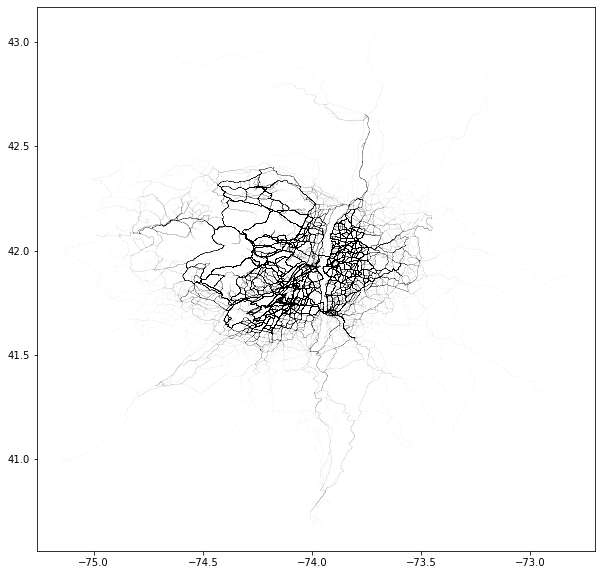

In [129]:
plt.figure(figsize=(10, 10))
for rte_id in RTE_IDS:
    lats, lons = get_lat_lons_of_route(rte_id, grid_pts_fine, gridpts_at_rte_fine)
    plt.plot(lons, lats, 'k.', markersize=0.005)

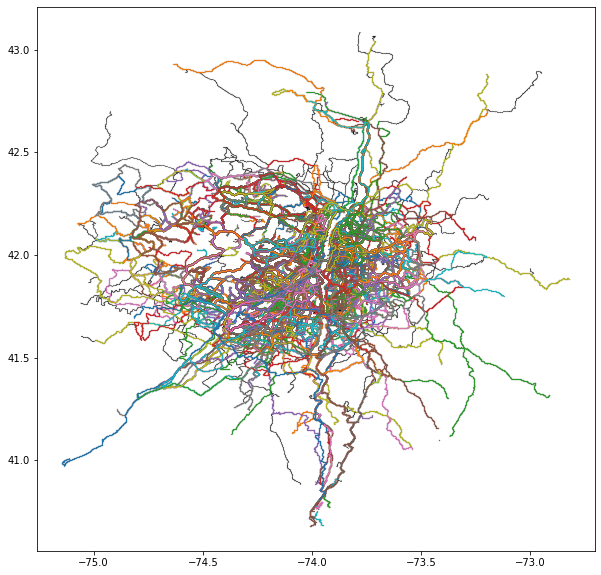

In [124]:
plt.figure(figsize=(10, 10))
plt.plot(grid_pts_fine.lon, grid_pts_fine.lat, 'k.', markersize=0.1)
lab = -1
for rte_id in rte_clustered[rte_clustered.labels == lab].index.tolist():
    lats, lons = get_lat_lons_of_route(rte_id, grid_pts_fine, gridpts_at_rte_fine)
    plt.plot(lons, lats, linestyle='', markersize=0.25, marker='.')
for lab in lab_counts.label:
    if lab == -1: continue
    lats, lons = get_lat_lons_of_route(rte_clustered[rte_clustered.labels == lab].index[0],
                                      grid_pts_fine, gridpts_at_rte_fine)
    plt.plot(lons, lats, linestyle='', markersize=0.25, marker='.')
# plt.xlim([-74.8, -73.2])
# plt.ylim([41., 42.6])

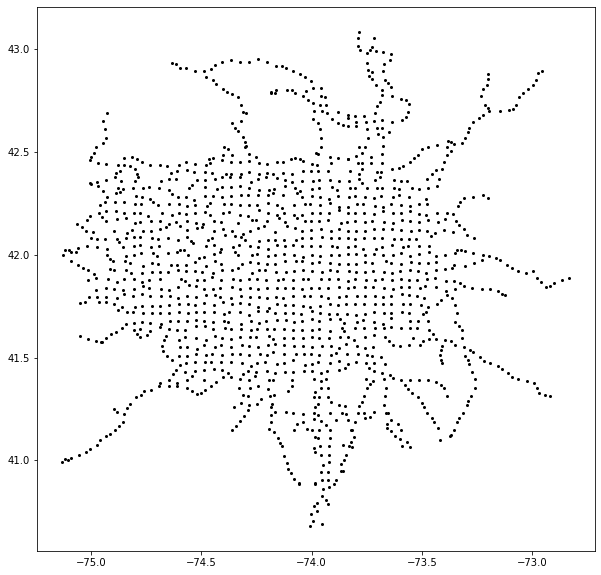

In [117]:
plt.figure(figsize=(10, 10))
plt.plot(grid_pts.lon, grid_pts.lat, 'k.', markersize=1/25*100)

(41.0, 42.6)

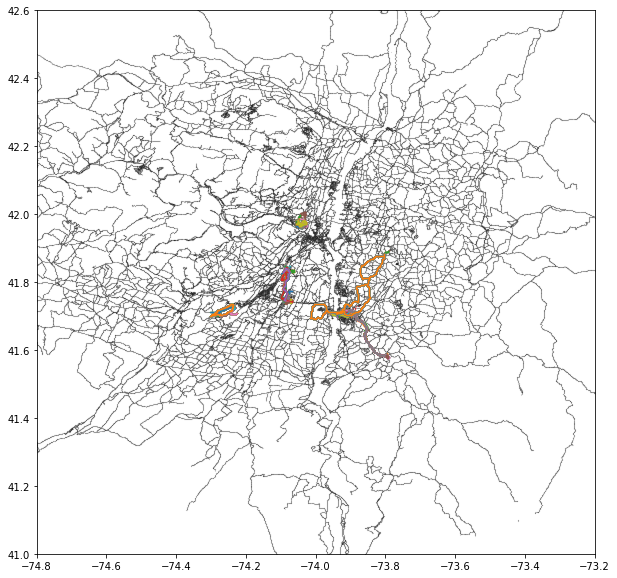

In [97]:
plt.figure(figsize=(10, 10))
plt.plot(grid_pts_fine.lon, grid_pts_fine.lat, 'k.', markersize=0.1)
labs = [2811, 2913, 1846, 2063, 2095]
for lab in labs:
    for rte_id in rte_clustered[rte_clustered.labels == lab].index.tolist():
        lats, lons = get_lat_lons_of_route(rte_id, grid_pts_fine, gridpts_at_rte_fine)
        plt.plot(lons, lats, linestyle='', markersize=0.75, marker='.')
plt.xlim([-74.8, -73.2])
plt.ylim([41., 42.6])
    

In [94]:
# lab_counts['n_sets'] = 0
# for i, row in lab_counts.iterrows():
#     lab = row.label
#     grid_ids = rte_clustered[rte_clustered.labels == lab].grid_ids.values.tolist()
#     lab_counts.at[i, 'n_sets'] = len(set(tuple(gi for gi in rt) for rt in grid_ids))
#     break
lab_counts[lab_counts.n_rtes > 100].label.tolist()
# plt.plot(grid_pts.loc[])
# rte_ids = rte_clustered[rte_clustered.labels]

[-1, 2811, 2913, 1846, 2063, 2095]

Text(0, 0.5, 'Unique sets of grid points in cluster')

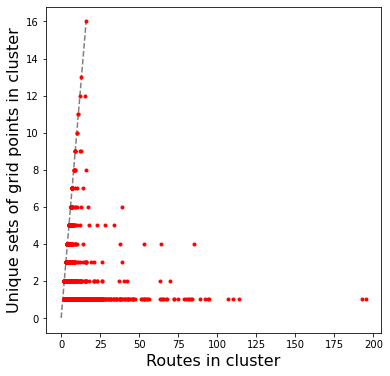

In [131]:
plt.figure(figsize=(6, 6))
plt.plot([0, 16], [0, 16], '--', color=(0.5, 0.5, 0.5))
plt.plot(lab_counts[lab_counts.label >= 0].n_rtes, lab_counts[lab_counts.label >= 0].n_sets, 'r.')
ftsz = 16
plt.xlabel('Routes in cluster', fontsize=ftsz)
plt.ylabel('Unique sets of grid points in cluster', fontsize=ftsz)

# plt.gca().set_fontsize(16)